In [1]:
%%capture
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import keras
import tensorflow as tf
%matplotlib inline

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
# Get a grayscale array of an input image file path
def get_img_arr(input_file_path):
    img = load_img(input_file_path, grayscale=True, target_size=(224, 224))
    return np.expand_dims(img_to_array(np.stack((img,)*3, -1)), axis=0)

# Split data into training and test
def split_data(self, y_all, X_all, split=0.7, seed=0):

    indices = np.arange(y_all.shape[0])

    X_unlab = X_all[(y_all == -1).flatten()]
    ind_unlab = indices[(y_all == -1).flatten()]

    y_valid = y_all[y_all != -1]
    X_valid = X_all[(y_all != -1).flatten()]
    ind_valid = indices[(y_all != -1).flatten()]

    X_train, X_test, y_train, y_test, ind_train, ind_test =\
            train_test_split(X_valid, y_valid, ind_valid,\
            train_size=split, random_state=seed)

    return y_train, X_train, ind_train, y_test, X_test, ind_test, X_unlab, ind_unlab

# Scatter plot for t-distributed stochastic neighbor embedding
def plot_tsne(xy, colors=None, alpha=0.6, figsize=(10,10), s=50, cmap='jet'):
    plt.figure(figsize=figsize, facecolor='white')
    plt.margins(0)
    plt.axis('off')
    fig = plt.scatter(xy[:,0], xy[:,1], c=colors, cmap=cmap, alpha=alpha, s=s, lw=0)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [4]:
path_base = 'Intermediates-Help/' + '1st problem/'
path_A = path_base + 'pA'
path_B = path_base + 'pB1'
path_D = path_base + 'Diakanemes'

files_A = []
for root, dirs, files in os.walk(path_A):
    for file in files:
        if file.endswith("tif"):
             files_A.append(os.path.join(root, file))
                
files_B = []
for root, dirs, files in os.walk(path_B):
    for file in files:
        if file.endswith("tif"):
             files_B.append(os.path.join(root, file))
                
files_D = []
for root, dirs, files in os.walk(path_D):
    for file in files:
        if file.endswith("tif"):
             files_D.append(os.path.join(root, file))
                
print('A: ', len(files_A), ', B: ', len(files_B), ', C:', len(files_D))

A:  269 , B:  351 , C: 141


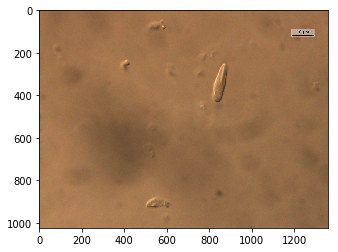

In [5]:
# Check that images loaded into lists
x = cv.imread(files_A[0])
plt.imshow(x)

In [7]:
# Gather all training data
num_classes = 2
X_A = np.vstack(map(get_img_arr, files_A))
X_B = np.vstack(map(get_img_arr, files_B))
y_A = np.ones(X_A.shape[0]).reshape(-1,1)
y_B = np.zeros(X_B.shape[0]).reshape(-1,1)
X_all = np.vstack((X_A, X_B))
y_all = np.vstack((y_A, y_B))
y_train_vec, X_train, ind_train, y_test_vec, X_test, ind_test, X_unlab, ind_unlab =\
        split_data(y_all, X_all, split=0.7, seed=0)
y_train = to_categorical(y_train_vec)
y_test = to_categorical(y_test_vec)

TypeError: split_data() missing 1 required positional argument: 'X_all'

In [ ]:
# Load pre-trained model w/out final FC layer
base_model = ResNet50(include_top=False, weights='imagenet', classes=2)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Model w/ new final layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all previous layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a data generator for augmentation    
data_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

data_gen.fit(X_train)

model.compile(optimizer=SGD(lr=0.03, decay=1e-4, momentum=0.9), loss='categorical_crossentropy')
model.fit_generator(data_gen.flow(X_train, y_train, batch_size=30),
                    steps_per_epoch=len(X_train)//30, epochs=10)

In [ ]:
# Compute test outputs
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Check top 1 test accuracy
train_accuracy = metrics.accuracy_score(y_train, y_pred_train.round())
test_accuracy = metrics.accuracy_score(y_test, y_pred_test.round())

print(train_accuracy, test_accuracy)

In [ ]:
# Unfreeze more final layers
num_layers = len(base_model.layers)
for layer in model.layers[:num_layers-8]:
   layer.trainable = False
for layer in model.layers[num_layers-8:]:
   layer.trainable = True

model.compile(optimizer=SGD(lr=0.003, decay=1e-5, momentum=0.9), loss='categorical_crossentropy')
model.fit_generator(data_gen.flow(X_train, y_train, batch_size=30),
                    steps_per_epoch=len(X_train)//30, epochs=10)

In [ ]:
# Compute test outputs
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Check top 1 test accuracy
train_accuracy = metrics.accuracy_score(y_train, y_pred_train.round())
test_accuracy = metrics.accuracy_score(y_test, y_pred_test.round())

print(train_accuracy, test_accuracy)

In [ ]:
model.save('bb_model_8.h5') 

In [ ]:
embedding_model = Model(inputs=model.input, outputs=model.layers[-5].output)
embeddings = embedding_model.predict(X_train)

In [ ]:
emb_feats = embeddings.reshape(embeddings.shape[0],-1)

# First 20 principal components
pca = PCA(n_components=20)
pca_feats = pca.fit_transform(emb_feats)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

In [ ]:
# t-SNE on principal components
tsne = TSNE(n_components=2)
tsne_res1 = tsne.fit_transform(pca_feats)
tsne_res2 = tsne.fit_transform(emb_feats)

In [ ]:
plot_tsne(tsne_res1,colors=y_train_vec)

In [ ]:
plot_tsne(tsne_res2,colors=y_train_vec)

In [ ]:
model.layers